# Collision Prediction - 0.1 step-length LSTM

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
non_collision_datasets = {}
collision_datasets = {}

for i in range(1, 6):
    non_collision_file = f'datasets/simulation_no_collision_{i}_dataset.csv'
    collision_file = f'datasets/simulation_collision_{i}_dataset.csv'
    non_collision_datasets[f'simulation_no_collision_{i}'] = pd.read_csv(non_collision_file).drop(columns=['ego_id','nearest_vehicle_id','collision_occurred'])
    collision_datasets[f'simulation_collision_{i}'] = pd.read_csv(collision_file).drop(columns=['ego_id','nearest_vehicle_id','collision_occurred'])

non_collision_datasets.keys(), collision_datasets.keys()

(dict_keys(['simulation_no_collision_1', 'simulation_no_collision_2', 'simulation_no_collision_3', 'simulation_no_collision_4', 'simulation_no_collision_5']),
 dict_keys(['simulation_collision_1', 'simulation_collision_2', 'simulation_collision_3', 'simulation_collision_4', 'simulation_collision_5']))

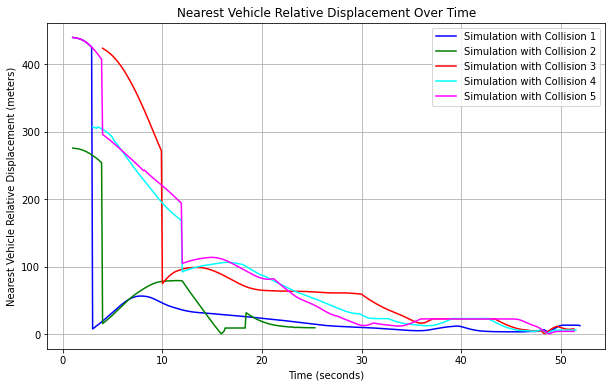

In [3]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

for i, color in zip(range(1, 6), colors):
    plt.plot(collision_datasets[f'simulation_collision_{i}']['time'],
             collision_datasets[f'simulation_collision_{i}']['nearest_vehicle_relative_displacement'],
             label=f'Simulation with Collision {i}',
             color=color)

plt.xlabel('Time (seconds)')
plt.ylabel('Nearest Vehicle Relative Displacement (meters)')
plt.title('Nearest Vehicle Relative Displacement Over Time')
plt.legend()
plt.grid(True)
plt.show()

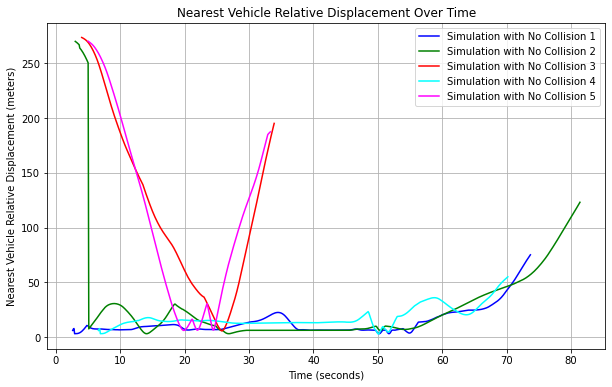

In [4]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

for i, color in zip(range(1, 6), colors):
    plt.plot(non_collision_datasets[f'simulation_no_collision_{i}']['time'],
             non_collision_datasets[f'simulation_no_collision_{i}']['nearest_vehicle_relative_displacement'],
             label=f'Simulation with No Collision {i}',
             color=color)

plt.xlabel('Time (seconds)')
plt.ylabel('Nearest Vehicle Relative Displacement (meters)')
plt.title('Nearest Vehicle Relative Displacement Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Study 1: Focusing on a single dataset from the simulation with the occurrence of a collision.

In [5]:
data = collision_datasets['simulation_collision_1'].drop(columns=['time'])
data

,ego_speed,ego_acceleration,ego_x,ego_y,nearest_vehicle_speed,nearest_vehicle_acceleration,nearest_vehicle_relative_displacement
0,0.00,0.00,244.90,4.8,1.37,2.50,439.394884
1,0.03,0.34,244.90,4.8,1.63,2.55,439.234922
2,0.10,0.64,244.89,4.8,1.88,2.57,439.034970
3,0.21,1.12,244.87,4.8,2.14,2.58,438.795027
4,0.40,1.86,244.83,4.8,2.40,2.60,438.515094
...,...,...,...,...,...,...,...
505,0.00,0.00,-1.60,-10.4,0.00,0.00,13.242356
506,0.00,0.00,-1.60,-10.4,0.00,0.00,13.242356
507,0.00,0.00,-1.60,-10.4,3.65,-0.05,13.129943
508,0.00,0.00,-1.60,-10.4,3.62,-0.30,12.825677


In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.select_dtypes(include=[np.number]))

def series_ds(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [('var%d(t+%d)' % (j+1, i)) if i != 0 else ('var%d(t)' % (j+1)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

n_lags = 15  # Number of time lags
n_features = scaled_data.shape[1] 
n_out_steps = 5  # Number of future time steps to predict
reframed_ds = series_ds(scaled_data, n_lags, n_out_steps)
reframed_ds

,var1(t-15),var2(t-15),var3(t-15),var4(t-15),var5(t-15),var6(t-15),var7(t-15),var1(t-14),var2(t-14),var3(t-14),...,var5(t+3),var6(t+3),var7(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var6(t+4),var7(t+4)
15,0.000000,0.577125,1.000000,1.000000,0.107451,0.922266,1.000000,0.001584,0.594963,1.000000,...,0.461961,0.897233,0.970618,0.449842,0.844176,0.972373,1.000000,0.480784,0.903821,0.967249
16,0.001584,0.594963,1.000000,1.000000,0.127843,0.928854,0.999633,0.005280,0.610703,0.999959,...,0.480784,0.903821,0.967249,0.475713,0.835257,0.968722,1.000000,0.000000,0.592885,0.010382
17,0.005280,0.610703,0.999959,1.000000,0.147451,0.931489,0.999175,0.011088,0.635887,0.999878,...,0.000000,0.592885,0.010382,0.503168,0.850997,0.964868,1.000000,0.000000,0.592885,0.012560
18,0.011088,0.635887,0.999878,1.000000,0.167843,0.932806,0.998625,0.021119,0.674711,0.999716,...,0.000000,0.592885,0.012560,0.532207,0.866737,0.960771,1.000000,0.008627,0.739130,0.014852
19,0.021119,0.674711,0.999716,1.000000,0.188235,0.935441,0.997983,0.035903,0.724029,0.999432,...,0.008627,0.739130,0.014852,0.563358,0.882476,0.956471,0.789474,0.021961,0.815547,0.018288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.385956,0.246065,0.000892,0.102632,0.425098,0.000000,0.016436,0.348469,0.204617,0.000527,...,0.000000,0.592885,0.023064,0.000000,0.577125,0.000000,0.000000,0.000000,0.592885,0.023064
502,0.348469,0.204617,0.000527,0.059211,0.389804,0.000000,0.018286,0.307814,0.173662,0.000203,...,0.000000,0.592885,0.023064,0.000000,0.577125,0.000000,0.000000,0.000000,0.592885,0.023064
503,0.307814,0.173662,0.000203,0.021711,0.354510,0.000000,0.019947,0.000000,0.577125,0.000000,...,0.000000,0.592885,0.023064,0.000000,0.577125,0.000000,0.000000,0.286275,0.586298,0.022807
504,0.000000,0.577125,0.000000,0.000000,0.319216,0.000000,0.021229,0.000000,0.577125,0.000000,...,0.286275,0.586298,0.022807,0.000000,0.577125,0.000000,0.000000,0.283922,0.553360,0.022109


In [7]:
values = reframed_ds.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

n_obs = n_lags * n_features
X_train, X_test = train[:, :n_obs], test[:, :n_obs]

y_train = train[:, -n_out_steps*n_features:]
y_test = test[:, -n_out_steps*n_features:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((392, 105), (392, 35), (99, 105), (99, 35))

In [8]:
# Reshape [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_lags, n_features))
X_test = X_test.reshape((X_test.shape[0], n_lags, n_features))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((392, 15, 7), (392, 35), (99, 15, 7), (99, 35))

In [9]:
# multivariate forecasting
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(LSTM(50, activation='relu',return_sequences=False))
model.add(Dense(n_out_steps * n_features * 5))  
model.add(Dropout(0.5))  
model.add(Dense(n_out_steps * n_features))  
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 100)           43200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 175)               8925      
                                                                 
 dropout (Dropout)           (None, 175)               0         
                                                                 
 dense_1 (Dense)             (None, 35)                6160      
                                                                 
Total params: 88485 (345.64 KB)
Trainable params: 88485 (345.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='min', min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test), verbose=2, shuffle=False, callbacks=[early_stopping,reduce_lr])

Epoch 1/100
392/392 - 3s - loss: 0.2774 - val_loss: 0.1860 - lr: 1.0000e-05 - 3s/epoch - 7ms/step
Epoch 2/100
392/392 - 1s - loss: 0.2348 - val_loss: 0.1473 - lr: 1.0000e-05 - 1s/epoch - 3ms/step
Epoch 3/100
392/392 - 1s - loss: 0.1460 - val_loss: 0.0834 - lr: 1.0000e-05 - 1s/epoch - 4ms/step
Epoch 4/100
392/392 - 1s - loss: 0.0943 - val_loss: 0.0715 - lr: 1.0000e-05 - 1s/epoch - 3ms/step
Epoch 5/100
392/392 - 1s - loss: 0.0790 - val_loss: 0.0659 - lr: 1.0000e-05 - 1s/epoch - 3ms/step
Epoch 6/100
392/392 - 1s - loss: 0.0699 - val_loss: 0.0639 - lr: 1.0000e-05 - 1s/epoch - 3ms/step
Epoch 7/100
392/392 - 1s - loss: 0.0648 - val_loss: 0.0625 - lr: 1.0000e-05 - 1s/epoch - 3ms/step
Epoch 8/100
392/392 - 1s - loss: 0.0604 - val_loss: 0.0616 - lr: 1.0000e-05 - 1s/epoch - 3ms/step
Epoch 9/100
392/392 - 1s - loss: 0.0564 - val_loss: 0.0606 - lr: 1.0000e-05 - 1s/epoch - 3ms/step
Epoch 10/100
392/392 - 1s - loss: 0.0526 - val_loss: 0.0595 - lr: 1.0000e-05 - 1s/epoch - 3ms/step
Epoch 11/100
392/39

Epoch 84/100
392/392 - 1s - loss: 0.0130 - val_loss: 0.0389 - lr: 1.0000e-05 - 1s/epoch - 3ms/step
Epoch 85/100
392/392 - 1s - loss: 0.0131 - val_loss: 0.0397 - lr: 1.0000e-05 - 1s/epoch - 3ms/step
Epoch 86/100

Epoch 86: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
392/392 - 1s - loss: 0.0129 - val_loss: 0.0388 - lr: 1.0000e-05 - 1s/epoch - 3ms/step
Epoch 87/100
392/392 - 1s - loss: 0.0131 - val_loss: 0.0386 - lr: 8.0000e-06 - 1s/epoch - 3ms/step
Epoch 88/100
392/392 - 1s - loss: 0.0130 - val_loss: 0.0381 - lr: 8.0000e-06 - 1s/epoch - 3ms/step
Epoch 89/100
392/392 - 1s - loss: 0.0130 - val_loss: 0.0387 - lr: 8.0000e-06 - 1s/epoch - 3ms/step
Epoch 90/100
392/392 - 1s - loss: 0.0125 - val_loss: 0.0384 - lr: 8.0000e-06 - 1s/epoch - 3ms/step
Epoch 91/100
392/392 - 1s - loss: 0.0126 - val_loss: 0.0385 - lr: 8.0000e-06 - 1s/epoch - 3ms/step
Epoch 92/100
392/392 - 1s - loss: 0.0123 - val_loss: 0.0384 - lr: 8.0000e-06 - 1s/epoch - 3ms/step
Epoch 93/100

Epoch 93: ReduceL

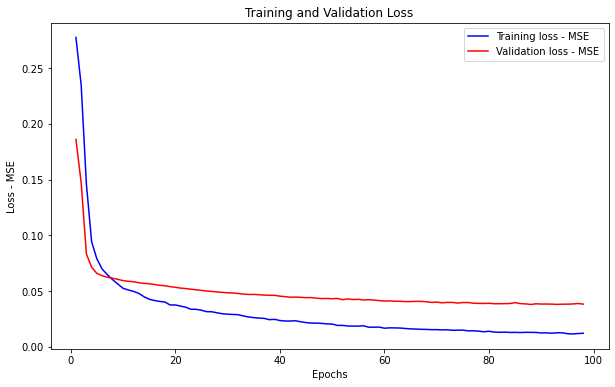

In [12]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss - MSE')
plt.plot(epochs, val_loss, 'r', label='Validation loss - MSE')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()

plt.show()

In [13]:
yhat = model.predict(X_test)
yhat_rs = yhat.reshape(-1, 7)
y_test_rs = y_test.reshape(-1,7)

inv_yhat = scaler.inverse_transform(yhat_rs)
inv_y = scaler.inverse_transform(y_test_rs)

mse = mean_squared_error(inv_y, inv_yhat, multioutput='raw_values')
print('Test MSE for each variable:', mse)

4/4 [==============================] - 0s 5ms/step
Test MSE for each variable: [  6.10811017  19.26234127 995.31322883  18.51147084   3.83274638
   4.50521324  57.17225559]


In [14]:
test_data = collision_datasets['simulation_collision_4']
test_data_prev_15 = test_data[(test_data['time'] >= 47.0) & (test_data['time'] <= 48.4)].drop(columns=['time'])
test_data_next_5 = test_data[(test_data['time'] >= 48.5) & (test_data['time'] <= 48.9)].drop(columns=['time']) #collision at 48.7

In [15]:
n_features_test= len(test_data_prev_15.columns)
n_lags_test = 15

In [16]:
test_prev_15_scaled = scaler.transform(test_data_prev_15)
test_prev_15_scaled = test_prev_15_scaled.reshape((1, n_lags_test, n_features_test))
y_next = model.predict(test_prev_15_scaled)

1/1 [==============================] - 0s 14ms/step


In [17]:
test_data_pred_next_5 = pd.DataFrame(scaler.inverse_transform(y_next.reshape((5,7))),columns=['ego_speed', 'ego_acceleration', 'ego_x', 'ego_y',
       'nearest_vehicle_speed', 'nearest_vehicle_acceleration',
       'nearest_vehicle_relative_displacement'])

#### Previous 15 timesteps:

In [18]:
test_data_prev_15 

,ego_speed,ego_acceleration,ego_x,ego_y,nearest_vehicle_speed,nearest_vehicle_acceleration,nearest_vehicle_relative_displacement
440,2.52,-7.62,5.64,0.92,7.31,2.16,4.333509
441,1.77,-7.50,5.46,0.89,7.55,2.42,4.136496
442,1.23,-5.31,5.34,0.88,7.76,2.11,3.982010
443,0.76,-4.71,5.26,0.87,7.99,2.26,3.930051
444,1.36,6.00,5.13,0.84,8.21,2.25,4.023146
445,1.96,6.00,4.96,0.74,8.45,2.34,4.291352
446,2.56,5.98,4.74,0.61,8.70,2.54,4.660225
447,3.16,6.02,4.47,0.44,8.96,2.58,5.112583
448,3.77,6.08,4.15,0.25,9.19,2.26,5.597330
449,4.34,5.66,3.78,0.03,9.42,2.38,6.123602


#### Actual 5 timesteps:

In [19]:
test_data_next_5

,ego_speed,ego_acceleration,ego_x,ego_y,nearest_vehicle_speed,nearest_vehicle_acceleration,nearest_vehicle_relative_displacement
455,7.27,2.54,0.89,-2.24,5.09,-4.50,2.023858
456,7.37,1.05,0.51,-2.88,4.65,-4.48,1.668323
457,7.51,1.35,0.13,-3.52,4.26,-3.88,1.938891
458,7.67,1.65,-0.27,-4.18,3.93,-3.28,2.631881
459,6.67,-10.00,-0.61,-4.75,3.66,-2.68,3.381627


#### Predicted 5 timesteps:

In [20]:
test_data_pred_next_5

,ego_speed,ego_acceleration,ego_x,ego_y,nearest_vehicle_speed,nearest_vehicle_acceleration,nearest_vehicle_relative_displacement
0,5.530689,0.232990,29.735617,3.260863,6.966780,0.427177,-1.667304
1,5.679511,0.085402,40.785477,2.310704,6.867776,0.539948,8.562242
2,4.875995,-0.034054,43.300751,3.080216,6.802257,0.233234,13.686946
3,5.323971,-0.256757,45.390308,2.509929,6.707571,0.063324,6.587652
4,5.116354,0.133540,34.776871,2.950565,6.308828,0.430363,4.420842


In [21]:
mse = mean_squared_error(test_data_next_5, test_data_pred_next_5, multioutput='raw_values')
print('MSE for each variable:', mse)

MSE for each variable: [   4.14772188   22.89854217 1530.99834482   40.9639234     5.92701854
   17.44956337   43.17913427]


## Study 2: Focusing on all 5 datasets from the simulation with the occurrence of a collision.

In [26]:
test_collision = collision_datasets['simulation_collision_4']
del collision_datasets['simulation_collision_4']

In [66]:
def series_ds(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [('var%d(t+%d)' % (j+1, i)) if i != 0 else ('var%d(t)' % (j+1)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [67]:
reframed_data_all_collision = {}
scaler = MinMaxScaler()
scaled_data_cs = scaler.fit_transform(collision_datasets['simulation_collision_1'].drop(columns=['time']).select_dtypes(include=[np.number]))
n_lags = 15  # Number of time lags
n_features = scaled_data_cs.shape[1] 
n_out_steps = 5  # Number of future time steps to predict
values = series_ds(scaled_data_cs, n_lags, n_out_steps)    
n_train_hours = int(len(values) * 0.8)
train = values.iloc[:n_train_hours, :]
test = values.iloc[n_train_hours:, :]

n_obs = n_lags * n_features
X_train, X_test = train.iloc[:, :n_obs], test.iloc[:, :n_obs]

y_train = train.iloc[:, -n_out_steps*n_features:].values
y_test = test.iloc[:, -n_out_steps*n_features:].values

X_train = X_train.values.reshape((X_train.shape[0], n_lags, n_features))
X_test = X_test.values.reshape((X_test.shape[0], n_lags, n_features))

reframed_data_all_collision['simulation_collision_1'] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
col_ls = list(collision_datasets.keys())
col_ls.pop(0)

for sim in col_ls:
    scaled_data_cs = scaler.transform(collision_datasets[sim].drop(columns=['time']).select_dtypes(include=[np.number]))
    n_lags = 15  # Number of time lags
    n_features = scaled_data_cs.shape[1] 
    n_out_steps = 5  # Number of future time steps to predict
    values = series_ds(scaled_data_cs, n_lags, n_out_steps)    
    n_train_hours = int(len(values) * 0.8)
    train = values.iloc[:n_train_hours, :]
    test = values.iloc[n_train_hours:, :]

    n_obs = n_lags * n_features
    X_train, X_test = train.iloc[:, :n_obs], test.iloc[:, :n_obs]

    y_train = train.iloc[:, -n_out_steps*n_features:].values
    y_test = test.iloc[:, -n_out_steps*n_features:].values

    X_train = X_train.values.reshape((X_train.shape[0], n_lags, n_features))
    X_test = X_test.values.reshape((X_test.shape[0], n_lags, n_features))

    reframed_data_all_collision[sim] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

reframed_data_all_collision.keys()

dict_keys(['simulation_collision_1', 'simulation_collision_2', 'simulation_collision_3', 'simulation_collision_5'])

In [59]:
# multivariate forecasting
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(LSTM(50, activation='relu',return_sequences=False))
model.add(Dense(n_out_steps * n_features * 5))  
model.add(Dropout(0.5))  
model.add(Dense(n_out_steps * n_features))  
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 15, 100)           43200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                30200     
                                                                 
 dense_10 (Dense)            (None, 175)               8925      
                                                                 
 dropout_5 (Dropout)         (None, 175)               0         
                                                                 
 dense_11 (Dense)            (None, 35)                6160      
                                                                 
Total params: 88485 (345.64 KB)
Trainable params: 88485 (345.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
loss_ls = []
val_loss_ls = []
for sim in reframed_data_all_collision.keys():
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, verbose=1, mode='min', min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
    history_ego = model.fit(reframed_data_all_collision[sim]['X_train'], 
                        reframed_data_all_collision[sim]['y_train'], epochs=30, batch_size=1, 
                        validation_data=(reframed_data_all_collision[sim]['X_test'], 
                                         reframed_data_all_collision[sim]['y_test']), 
                        verbose=2, shuffle=False, callbacks=[reduce_lr,early_stopping])
    loss_ls.append(history_ego.history['loss'])
    val_loss_ls.append(history_ego.history['val_loss'])
    print(sim)

Epoch 1/30
392/392 - 3s - loss: 0.1300 - val_loss: 0.0668 - lr: 1.0000e-04 - 3s/epoch - 7ms/step
Epoch 2/30
392/392 - 1s - loss: 0.0443 - val_loss: 0.0613 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 3/30
392/392 - 1s - loss: 0.0371 - val_loss: 0.0559 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 4/30
392/392 - 1s - loss: 0.0314 - val_loss: 0.0512 - lr: 1.0000e-04 - 1s/epoch - 4ms/step
Epoch 5/30
392/392 - 1s - loss: 0.0281 - val_loss: 0.0499 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 6/30
392/392 - 1s - loss: 0.0244 - val_loss: 0.0476 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 7/30
392/392 - 1s - loss: 0.0217 - val_loss: 0.0440 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 8/30
392/392 - 1s - loss: 0.0204 - val_loss: 0.0424 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 9/30
392/392 - 1s - loss: 0.0182 - val_loss: 0.0444 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 10/30
392/392 - 1s - loss: 0.0170 - val_loss: 0.0408 - lr: 1.0000e-04 - 1s/epoch - 4ms/step
Epoch 11/30
392/392 - 1s - lo

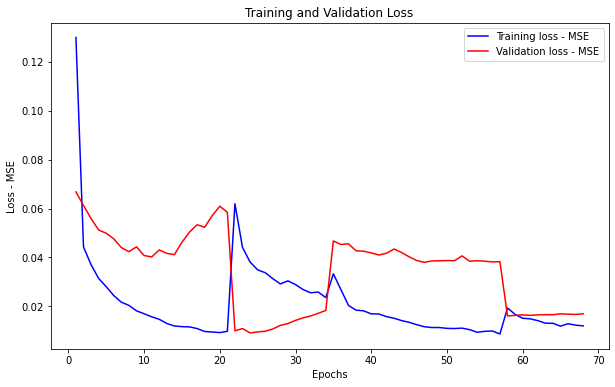

In [64]:
train_loss = [item for sublist in loss_ls for item in sublist]
val_loss = [item for sublist in val_loss_ls for item in sublist]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss - MSE')
plt.plot(epochs, val_loss, 'r', label='Validation loss - MSE')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()

plt.show()

In [41]:
test_data = test_collision.copy()
test_data_prev_15 = test_data[(test_data['time'] >= 47.0) & (test_data['time'] <= 48.4)].drop(columns=['time'])
test_data_next_5 = test_data[(test_data['time'] >= 48.5) & (test_data['time'] <= 48.9)].drop(columns=['time']) #collision at 48.7

In [42]:
n_features_test= len(test_data_prev_15.columns)
n_lags_test = 15

In [43]:
test_prev_15_scaled = scaler.transform(test_data_prev_15)
test_prev_15_scaled = test_prev_15_scaled.reshape((1, n_lags_test, n_features_test))
y_next = model.predict(test_prev_15_scaled)

1/1 [==============================] - 0s 139ms/step


In [44]:
test_data_pred_next_5 = pd.DataFrame(scaler.inverse_transform(y_next.reshape((5,7))),columns=['ego_speed', 'ego_acceleration', 'ego_x', 'ego_y',
       'nearest_vehicle_speed', 'nearest_vehicle_acceleration',
       'nearest_vehicle_relative_displacement'])

#### Previous 15 timesteps:

In [45]:
test_data_prev_15 

,ego_speed,ego_acceleration,ego_x,ego_y,nearest_vehicle_speed,nearest_vehicle_acceleration,nearest_vehicle_relative_displacement
440,2.52,-7.62,5.64,0.92,7.31,2.16,4.333509
441,1.77,-7.50,5.46,0.89,7.55,2.42,4.136496
442,1.23,-5.31,5.34,0.88,7.76,2.11,3.982010
443,0.76,-4.71,5.26,0.87,7.99,2.26,3.930051
444,1.36,6.00,5.13,0.84,8.21,2.25,4.023146
445,1.96,6.00,4.96,0.74,8.45,2.34,4.291352
446,2.56,5.98,4.74,0.61,8.70,2.54,4.660225
447,3.16,6.02,4.47,0.44,8.96,2.58,5.112583
448,3.77,6.08,4.15,0.25,9.19,2.26,5.597330
449,4.34,5.66,3.78,0.03,9.42,2.38,6.123602


#### Actual 5 timesteps:

In [46]:
test_data_next_5

,ego_speed,ego_acceleration,ego_x,ego_y,nearest_vehicle_speed,nearest_vehicle_acceleration,nearest_vehicle_relative_displacement
455,7.27,2.54,0.89,-2.24,5.09,-4.50,2.023858
456,7.37,1.05,0.51,-2.88,4.65,-4.48,1.668323
457,7.51,1.35,0.13,-3.52,4.26,-3.88,1.938891
458,7.67,1.65,-0.27,-4.18,3.93,-3.28,2.631881
459,6.67,-10.00,-0.61,-4.75,3.66,-2.68,3.381627


#### Predicted 5 timesteps:

In [47]:
test_data_pred_next_5

,ego_speed,ego_acceleration,ego_x,ego_y,nearest_vehicle_speed,nearest_vehicle_acceleration,nearest_vehicle_relative_displacement
0,3.216607,-1.767124,-5.701119,0.510598,6.093621,0.451250,6.336795
1,3.426393,-1.992658,-2.453146,0.459176,6.007215,0.481302,12.044146
2,3.317338,-1.890387,-4.849128,0.432850,6.005793,0.401064,10.212312
3,3.475820,-2.089043,-4.808394,0.535305,5.904314,0.332700,7.373904
4,3.204973,-1.988391,-2.583175,0.380252,5.809485,0.299588,4.445731


In [48]:
mse = mean_squared_error(test_data_next_5, test_data_pred_next_5, multioutput='raw_values')
print('MSE for each variable:', mse)

MSE for each variable: [15.8316017  23.29510109 20.3010489  16.57889843  2.88305628 17.87728949
 43.6655425 ]


## Study 3: Considering all 5 datasets from the simulation with the occurrence of a collision.

In [71]:
non_collision_datasets['simulation_no_collision_3']

,time,ego_speed,ego_acceleration,ego_x,ego_y,nearest_vehicle_speed,nearest_vehicle_acceleration,nearest_vehicle_relative_displacement
0,4.0,0.00,0.00,-4.7,194.90,3.92,2.36,273.524109
1,4.1,0.03,0.34,-4.7,194.90,4.17,2.57,273.237278
2,4.2,0.10,0.64,-4.7,194.89,4.42,2.53,272.929842
3,4.3,0.21,1.12,-4.7,194.87,4.68,2.52,272.595021
4,4.4,0.40,1.86,-4.7,194.83,4.94,2.63,272.225538
...,...,...,...,...,...,...,...,...
295,33.5,25.16,-2.59,-4.8,-190.22,0.00,0.00,185.540649
296,33.6,24.71,-4.48,-4.8,-192.69,0.00,0.00,188.009064
297,33.7,24.24,-4.78,-4.8,-195.11,0.00,0.00,190.427551
298,33.8,23.76,-4.75,-4.8,-197.49,0.00,0.00,192.806100


In [81]:
reframed_data_all_no_collision = {}
n_col_ls = list(non_collision_datasets.keys())
n_col_ls.pop(1)

for sim in n_col_ls:
    scaled_data_cs = scaler.transform(non_collision_datasets[sim].drop(columns=['time']).select_dtypes(include=[np.number]))
    n_lags = 15  # Number of time lags
    n_features = scaled_data_cs.shape[1] 
    n_out_steps = 5  # Number of future time steps to predict
    values = series_ds(scaled_data_cs, n_lags, n_out_steps)

    n_train_hours = int(len(values) * 0.8)
    train = values.iloc[:n_train_hours, :]
    test = values.iloc[n_train_hours:, :]

    n_obs = n_lags * n_features
    X_train, X_test = train.iloc[:, :n_obs], test.iloc[:, :n_obs]

    y_train = train.iloc[:, -n_out_steps*n_features:].values
    y_test = test.iloc[:, -n_out_steps*n_features:].values

    X_train = X_train.values.reshape((X_train.shape[0], n_lags, n_features))
    X_test = X_test.values.reshape((X_test.shape[0], n_lags, n_features))

    reframed_data_all_no_collision[sim] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

reframed_data_all_no_collision.keys()

dict_keys(['simulation_no_collision_1', 'simulation_no_collision_3', 'simulation_no_collision_4', 'simulation_no_collision_5'])

In [82]:
# multivariate forecasting
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(LSTM(50, activation='relu',return_sequences=False))
model.add(Dense(n_out_steps * n_features * 5))  
model.add(Dropout(0.5))  
model.add(Dense(n_out_steps * n_features))  
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 15, 100)           43200     
                                                                 
 lstm_13 (LSTM)              (None, 50)                30200     
                                                                 
 dense_12 (Dense)            (None, 175)               8925      
                                                                 
 dropout_6 (Dropout)         (None, 175)               0         
                                                                 
 dense_13 (Dense)            (None, 35)                6160      
                                                                 
Total params: 88485 (345.64 KB)
Trainable params: 88485 (345.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
loss_ls = []
val_loss_ls = []
for sim in reframed_data_all_collision.keys():
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, verbose=1, mode='min', min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
    history_ego_1 = model.fit(reframed_data_all_collision[sim]['X_train'], 
                        reframed_data_all_collision[sim]['y_train'], epochs=30, batch_size=1, 
                        validation_data=(reframed_data_all_collision[sim]['X_test'], 
                                         reframed_data_all_collision[sim]['y_test']), 
                        verbose=2, shuffle=False, callbacks=[reduce_lr,early_stopping])
    loss_ls.append(history_ego_1.history['loss'])
    val_loss_ls.append(history_ego_1.history['val_loss'])
    print(sim)

for sim in reframed_data_all_no_collision.keys():
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, verbose=1, mode='min', min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
    history_non_ego = model.fit(reframed_data_all_no_collision[sim]['X_train'], 
                        reframed_data_all_no_collision[sim]['y_train'], epochs=30, batch_size=1, 
                        validation_data=(reframed_data_all_no_collision[sim]['X_test'], 
                                         reframed_data_all_no_collision[sim]['y_test']), 
                        verbose=2, shuffle=False, callbacks=[reduce_lr,early_stopping])
    loss_ls.append(history_non_ego.history['loss'])
    val_loss_ls.append(history_non_ego.history['val_loss'])
    print(sim)

Epoch 1/30
392/392 - 2s - loss: 0.1323 - val_loss: 0.0690 - lr: 1.0000e-04 - 2s/epoch - 6ms/step
Epoch 2/30
392/392 - 1s - loss: 0.0476 - val_loss: 0.0577 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 3/30
392/392 - 1s - loss: 0.0384 - val_loss: 0.0539 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 4/30
392/392 - 1s - loss: 0.0315 - val_loss: 0.0499 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 5/30
392/392 - 1s - loss: 0.0269 - val_loss: 0.0457 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 6/30
392/392 - 1s - loss: 0.0238 - val_loss: 0.0437 - lr: 1.0000e-04 - 1s/epoch - 4ms/step
Epoch 7/30
392/392 - 1s - loss: 0.0214 - val_loss: 0.0397 - lr: 1.0000e-04 - 1s/epoch - 3ms/step
Epoch 8/30
392/392 - 1s - loss: 0.0181 - val_loss: 0.0376 - lr: 1.0000e-04 - 1s/epoch - 4ms/step
Epoch 9/30
392/392 - 1s - loss: 0.0176 - val_loss: 0.0420 - lr: 1.0000e-04 - 1s/epoch - 4ms/step
Epoch 10/30
392/392 - 1s - loss: 0.0163 - val_loss: 0.0409 - lr: 1.0000e-04 - 1s/epoch - 4ms/step
Epoch 11/30
392/392 - 1s - lo

Epoch 6/30
554/554 - 2s - loss: 0.0128 - val_loss: 9.4393 - lr: 4.3047e-05 - 2s/epoch - 3ms/step
Epoch 7/30
554/554 - 2s - loss: 0.0123 - val_loss: 13.8470 - lr: 4.3047e-05 - 2s/epoch - 3ms/step
Epoch 8/30
554/554 - 2s - loss: 0.0115 - val_loss: 64.0846 - lr: 4.3047e-05 - 2s/epoch - 3ms/step
Epoch 9/30
554/554 - 2s - loss: 0.0112 - val_loss: 299.0899 - lr: 4.3047e-05 - 2s/epoch - 4ms/step
Epoch 10/30

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.8742047036066654e-05.
554/554 - 2s - loss: 0.0108 - val_loss: 409.7665 - lr: 4.3047e-05 - 2s/epoch - 3ms/step
Epoch 11/30
554/554 - 2s - loss: 0.0106 - val_loss: 286.0313 - lr: 3.8742e-05 - 2s/epoch - 3ms/step
Epoch 12/30
554/554 - 2s - loss: 0.0103 - val_loss: 347.1856 - lr: 3.8742e-05 - 2s/epoch - 3ms/step
Epoch 13/30
554/554 - 2s - loss: 0.0103 - val_loss: 556.6901 - lr: 3.8742e-05 - 2s/epoch - 3ms/step
Epoch 14/30
554/554 - 2s - loss: 0.0094 - val_loss: 533.5920 - lr: 3.8742e-05 - 2s/epoch - 3ms/step
Epoch 15/30

Epoch 15: Reduce

Epoch 9/30
212/212 - 1s - loss: 0.5997 - val_loss: 1.3032 - lr: 2.8243e-05 - 729ms/epoch - 3ms/step
Epoch 10/30
212/212 - 1s - loss: 0.5768 - val_loss: 1.2261 - lr: 2.8243e-05 - 733ms/epoch - 3ms/step
Epoch 11/30
212/212 - 1s - loss: 0.5633 - val_loss: 0.8356 - lr: 2.8243e-05 - 717ms/epoch - 3ms/step
Epoch 12/30
212/212 - 1s - loss: 0.6192 - val_loss: 0.8298 - lr: 2.8243e-05 - 729ms/epoch - 3ms/step
Epoch 13/30
212/212 - 1s - loss: 0.5575 - val_loss: 0.7992 - lr: 2.8243e-05 - 722ms/epoch - 3ms/step
Epoch 14/30
212/212 - 1s - loss: 0.4852 - val_loss: 0.9050 - lr: 2.8243e-05 - 729ms/epoch - 3ms/step
Epoch 15/30
212/212 - 1s - loss: 0.4521 - val_loss: 1.0677 - lr: 2.8243e-05 - 729ms/epoch - 3ms/step
Epoch 16/30
212/212 - 1s - loss: 0.4738 - val_loss: 1.0522 - lr: 2.8243e-05 - 722ms/epoch - 3ms/step
Epoch 17/30
212/212 - 1s - loss: 0.4471 - val_loss: 0.8525 - lr: 2.8243e-05 - 722ms/epoch - 3ms/step
Epoch 18/30

Epoch 18: ReduceLROnPlateau reducing learning rate to 2.5418658333364876e-05.
2

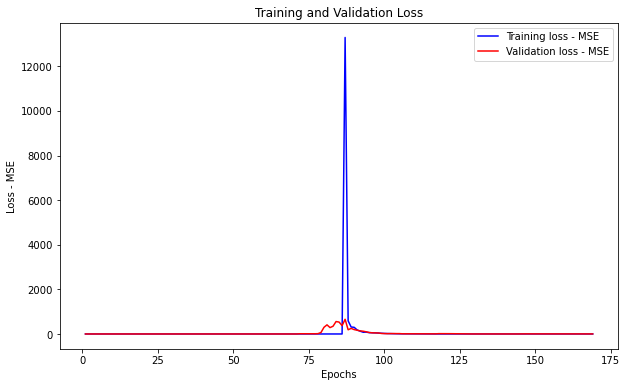

In [84]:
train_loss = [item for sublist in loss_ls for item in sublist]
val_loss = [item for sublist in val_loss_ls for item in sublist]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss - MSE')
plt.plot(epochs, val_loss, 'r', label='Validation loss - MSE')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()

plt.show()

In [85]:
test_data = test_collision.copy()
test_data_prev_15 = test_data[(test_data['time'] >= 47.0) & (test_data['time'] <= 48.4)].drop(columns=['time'])
test_data_next_5 = test_data[(test_data['time'] >= 48.5) & (test_data['time'] <= 48.9)].drop(columns=['time']) #collision at 48.7

In [86]:
n_features_test= len(test_data_prev_15.columns)
n_lags_test = 15

In [87]:
test_prev_15_scaled = scaler.transform(test_data_prev_15)
test_prev_15_scaled = test_prev_15_scaled.reshape((1, n_lags_test, n_features_test))
y_next = model.predict(test_prev_15_scaled)

1/1 [==============================] - 0s 149ms/step


In [88]:
test_data_pred_next_5 = pd.DataFrame(scaler.inverse_transform(y_next.reshape((5,7))),columns=['ego_speed', 'ego_acceleration', 'ego_x', 'ego_y',
       'nearest_vehicle_speed', 'nearest_vehicle_acceleration',
       'nearest_vehicle_relative_displacement'])

#### Previous 15 timesteps:

In [89]:
test_data_prev_15

,ego_speed,ego_acceleration,ego_x,ego_y,nearest_vehicle_speed,nearest_vehicle_acceleration,nearest_vehicle_relative_displacement
440,2.52,-7.62,5.64,0.92,7.31,2.16,4.333509
441,1.77,-7.50,5.46,0.89,7.55,2.42,4.136496
442,1.23,-5.31,5.34,0.88,7.76,2.11,3.982010
443,0.76,-4.71,5.26,0.87,7.99,2.26,3.930051
444,1.36,6.00,5.13,0.84,8.21,2.25,4.023146
445,1.96,6.00,4.96,0.74,8.45,2.34,4.291352
446,2.56,5.98,4.74,0.61,8.70,2.54,4.660225
447,3.16,6.02,4.47,0.44,8.96,2.58,5.112583
448,3.77,6.08,4.15,0.25,9.19,2.26,5.597330
449,4.34,5.66,3.78,0.03,9.42,2.38,6.123602


#### Actual 5 timesteps:

In [92]:
test_data_next_5

,ego_speed,ego_acceleration,ego_x,ego_y,nearest_vehicle_speed,nearest_vehicle_acceleration,nearest_vehicle_relative_displacement
455,7.27,2.54,0.89,-2.24,5.09,-4.50,2.023858
456,7.37,1.05,0.51,-2.88,4.65,-4.48,1.668323
457,7.51,1.35,0.13,-3.52,4.26,-3.88,1.938891
458,7.67,1.65,-0.27,-4.18,3.93,-3.28,2.631881
459,6.67,-10.00,-0.61,-4.75,3.66,-2.68,3.381627


#### Predicited 15 timesteps:

In [91]:
test_data_pred_next_5

,ego_speed,ego_acceleration,ego_x,ego_y,nearest_vehicle_speed,nearest_vehicle_acceleration,nearest_vehicle_relative_displacement
0,7.011085,-2.701354,3.553900,-5.337836,8.323498,-0.056874,7.447763
1,6.586177,-2.111078,19.834400,-6.061495,7.948454,-0.224143,23.322729
2,7.110813,-2.845597,4.552804,-6.721208,8.732163,-0.294258,33.649212
3,6.909030,-1.927503,-0.765039,-6.876007,8.786139,-0.641894,13.684005
4,7.568554,-2.163022,11.788939,-7.028240,7.982291,-0.590981,20.771879


In [93]:
mse = mean_squared_error(test_data_next_5, test_data_pred_next_5, multioutput='raw_values')
print('MSE for each variable:', mse)

MSE for each variable: [  0.44544802  25.85679736 110.81375426   8.48501234  16.71996858
  12.40696634 385.68936181]
